---

# **Imports**

In [6]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random
import ot

# **General functions**

In [7]:
def c(x, y):
    return np.abs(x - y)

---

# **Mathematical found optimal transport plan**
### Check the mathematical optimal transport plan found with math.

In [8]:
# Define the initial and final distributions
mu = uniform(loc=-1, scale=2)
nu = uniform(loc=-2, scale=4)

# Generate samples from mu and nu
x_samples = mu.rvs(size=1000)
y_samples = nu.rvs(size=1000)

# Discretization
n_bins = 100
x_bins = np.linspace(-1, 1, n_bins+1)
y_bins = np.linspace(-2, 2, n_bins+1)
mu_hist, _ = np.histogram(x_samples, bins=x_bins, density=True)
nu_hist, _ = np.histogram(y_samples, bins=y_bins, density=True)

# Initialization of P
P_init = np.outer(mu_hist, nu_hist)
P_init /= P_init.sum()

# Apply optimal transport plan to set up the P_opt variable
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2
P_opt = np.zeros_like(P_init)
for i, x in enumerate(x_centers):
    y_left = x - 1
    y_right = x + 1
    y_left_idx = np.searchsorted(y_centers, y_left) - 1 
    y_right_idx = np.searchsorted(y_centers, y_right) - 1
    P_opt[i, y_left_idx] = 0.5 * mu_hist[i]
    P_opt[i, y_right_idx] = 0.5 * mu_hist[i]

mu_a, mu_b = -1, 1
nu_a, nu_b = -2, 2

# Generate new y samples based on the optimal transport plan
new_y_samples = []
for x in x_samples:
    x_idx = np.searchsorted(x_bins, x) - 1
    y_probs = P_opt[x_idx] / P_opt[x_idx].sum()
    y_idx = np.random.choice(np.arange(len(y_centers)), p=y_probs)
    new_y_samples.append(y_centers[y_idx])

new_y_samples = np.array(new_y_samples)

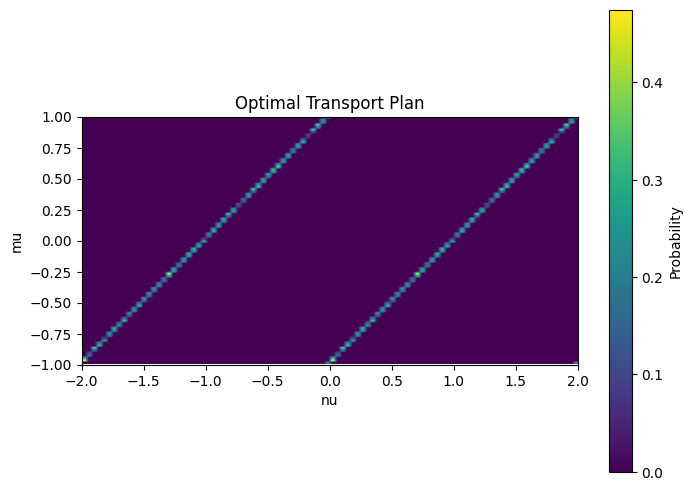

In [9]:
# Plot the optimal transport plan
plt.figure(figsize=(8, 6))
plt.imshow(P_opt, cmap='viridis', origin='lower', extent=[nu_a, nu_b, mu_a, mu_b])
plt.colorbar(label='Probability')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('Optimal Transport Plan')
plt.show()

In [10]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(new_y_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
expected_cost = np.mean(c(x_samples, new_y_samples))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(c(x_samples, new_y_samples))
rhs = np.sqrt(np.mean((x_samples - new_y_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(new_y_samples - x_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): True
Expected cost E[c(X, Y)]: 1.008170828530259
Inequality holds: True
Martingale difference: -0.012014790982358319
Martingale difference is close to 0: True
